<a href="https://colab.research.google.com/github/Sunkyoung/PyTorch-Study/blob/main/PyTorch_Study_05_VAE(Solution).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

Problem made by Junseon

## 1. Settings

### 1) Import required libraries

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

### 2) Set hyperparameters

In [31]:
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

## 2. Data

### 1) Download Data

In [32]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

In [33]:
mnist_train[0][0].size()    # (1, 28, 28)

torch.Size([1, 28, 28])

In [34]:
mnist_train[0][1]           # label

3

### 2) Set DataLoader

In [35]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [36]:
len(dataloaders["train"])

391

## 3. Model & Optimizer

In [37]:
# https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html
Image("img/vae_gaussian.png")

### 1) Model

In [38]:
# encoder : 2 layers model 784 -> 512 -> 256, with activation function
# sampling for reparameterization trick : 256 -> 10
# decoder : 3 layers model 10 -> 256 -> 512-> 784, with activation function , after 3 layers sigmoid function for classification

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(256, 10)
        self.fc_var = nn.Linear(256, 10)
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=10, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=784),
            nn.Sigmoid()
        )

    #input : x
    #output : mu, log_var            
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var
    
    #input : mu, log_var
    #output : reparameterized 'z'
    #using torch.randn_like(input) : return tensor with the same size as input that filled with random numbers from a normal distribution mean:0, variance:1
    #output of the encode is log_var, to make sigma positive make std as : sigma(std) = e^(log_var/2) 
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    #input : z
    #output : reconstructed x
    def decode(self, z):
        recon = self.decoder(z)
        return recon

    #input : x: (batch_size, 1, 28, 28)
    #output : out(reconstructed x), mu, log_var 
    # encoder -> input : (batchsize, -1)
        
    def forward(self, x):
        batch_size = x.size(0)                
        mu, log_var = self.encode(x.view(batch_size, -1))
        z = self.reparameterize(mu, log_var)
        out = self.decode(z)
        return out, mu, log_var

In [39]:
input, label = next(iter(dataloaders['train']))

In [40]:
input.shape #[128,1, 28, 28]
input.view(128, -1).shape

torch.Size([128, 784])

### 2) Loss func & Optimizer

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [42]:
BCE = torch.nn.BCELoss(reduction='sum')
#reduction : output will be summed
#BCE(input, target) : input, target(same shape as input)

# BCE : reconstructed error between x & recon_x
# KLD : analytical expression(lecture note의 p.46참고)
def loss_func(x, recon_x, mu, log_var):
    BCE_loss = BCE(recon_x, x.view(-1, 28*28))
    KLD_loss = torch.sum(mu**2 + log_var.exp() - log_var - 1)/2
    return BCE_loss + KLD_loss

In [43]:
model = VariationalAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [44]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, mu, log_var = model(inputs)
                    loss = criterion(inputs, outputs, mu, log_var)  # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [45]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 179.9319
val Loss: 139.6311

Epoch 1/9
----------
train Loss: 128.7355
val Loss: 121.8130

Epoch 2/9
----------
train Loss: 118.3951
val Loss: 115.7800

Epoch 3/9
----------
train Loss: 113.4514
val Loss: 112.5519

Epoch 4/9
----------
train Loss: 110.7222
val Loss: 110.4057

Epoch 5/9
----------
train Loss: 108.9658
val Loss: 108.6845

Epoch 6/9
----------
train Loss: 107.6249
val Loss: 107.9364

Epoch 7/9
----------
train Loss: 106.5696
val Loss: 107.0568

Epoch 8/9
----------
train Loss: 105.7373
val Loss: 106.3398

Epoch 9/9
----------
train Loss: 105.0123
val Loss: 105.5476

Training complete in 1m 7s
Best val Loss: 105.547621


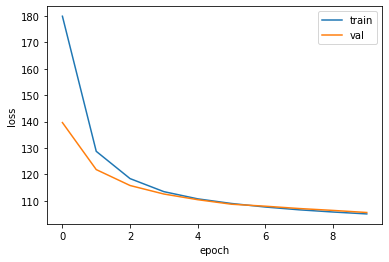

In [46]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. Check with Test Image (Can VAE reconstruct input images?)

In [47]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        outputs, mu, log_var = best_model(inputs)
        test_loss = loss_func(inputs, outputs, mu, log_var)
        
        running_loss += test_loss.item()

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

104.80911510009766


torch.Size([16, 784])


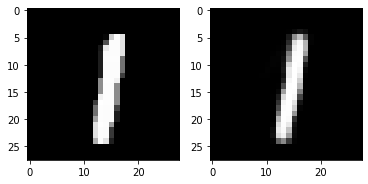

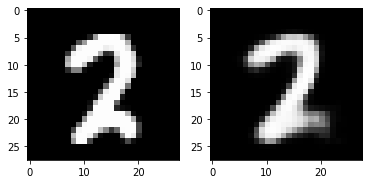

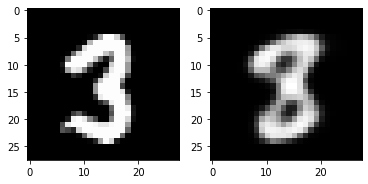

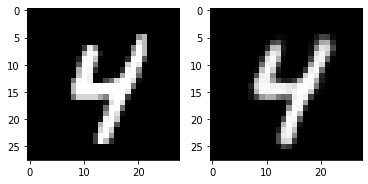

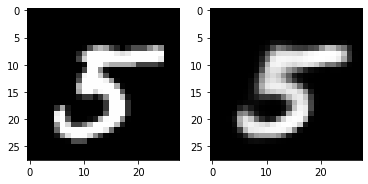

In [48]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy().reshape(28, 28),cmap='gray')
    plt.show()

## 6. Visualizing MNIST

In [49]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [50]:
train_dataset_array = mnist_train.dataset.data.numpy() / 255
train_dataset_array = np.float32(train_dataset_array)
labels = mnist_train.dataset.targets.numpy()

In [51]:
subset_indices = []
subset_indices_per_class = []

for i in range(10):
    indices = np.where(labels == i)[0]
    subset_size = len(indices) // 6
    subset_indices += indices[:subset_size].tolist()
    subset_indices_per_class.append(indices[:subset_size].tolist())

train_dataset_array = train_dataset_array[subset_indices]
labels = labels[subset_indices]

In [52]:
train_dataset_array = torch.tensor(train_dataset_array)
inputs = train_dataset_array.to(device)
outputs, mu, log_var = best_model(inputs)

In [53]:
encoded = mu.cpu().detach().numpy()
tsne = TSNE()   
X_train_2D = tsne.fit_transform(encoded)
X_train_2D = (X_train_2D - X_train_2D.min()) / (X_train_2D.max() - X_train_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


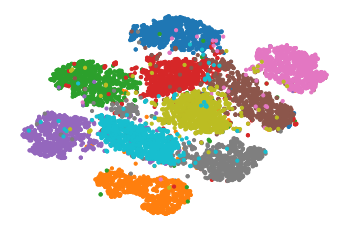

In [54]:
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

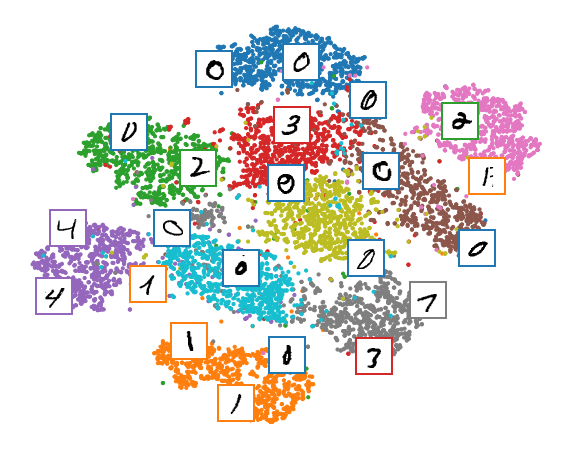

In [55]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_train_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

## 7. Walk through latent space of MNIST

In [56]:
encoded.shape

(9996, 10)

In [57]:
mean_encoded = []
for i in range(10):
    mean_encoded.append(encoded[np.where(labels == i)[0]].mean(axis=0))

In [58]:
selected_class = [1, 7]
samples = []
with torch.no_grad():
    for idx, coef in enumerate(np.linspace(0, 1, 10)):
        interpolated = coef * mean_encoded[selected_class[0]] + (1.-coef) * mean_encoded[selected_class[1]]
        samples.append(interpolated)
    samples = np.stack(samples)
    z = torch.tensor(samples).to(device)
    generated = best_model.decoder(z).cuda()

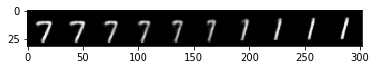

In [59]:
generated = generated.view(10, 1, 28, 28)
img = make_grid(generated, nrow=10)
npimg = img.cpu().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [60]:
selected_class = [1, 8]
samples = []
with torch.no_grad():
    for idx, coef in enumerate(np.linspace(0, 1, 10)):
        interpolated = coef * mean_encoded[selected_class[0]] + (1.-coef) * mean_encoded[selected_class[1]]
        samples.append(interpolated)
    samples = np.stack(samples)
    z = torch.tensor(samples).to(device)
    generated = best_model.decoder(z).cuda()


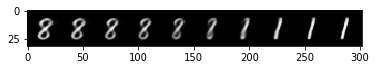

In [61]:
generated = generated.view(10, 1, 28, 28)
img = make_grid(generated, nrow=10)
npimg = img.cpu().numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')